# Perturbation study of 2D pure Z2 LGT on triangular lattice

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as scisp
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import jax.experimental.sparse as jsp
from qiskit.quantum_info import SparsePauliOp
from heavyhex_qft.triangular_z2 import TriangularZ2Lattice
from skqd_z2lgt.jax_experimental_sparse_linalg import lobpcg_standard
from skqd_z2lgt.mwpm import minimum_weight_link_state

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update('jax_enable_x64', True)

In [2]:
def sort_eigvec(evec):
    nplaq = int(np.round(np.log2(evec.shape[0])))        
    probs = np.square(np.abs(evec))
    sorted_idx = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_idx]
    sorted_plaqs = (sorted_idx[:, None] >> np.arange(nplaq)[::-1]) % 2
    return sorted_idx, sorted_probs, sorted_plaqs

def print_plaqs(plaqs, probs, nline=20):
    for conf, prob in zip(plaqs[:nline], probs[:nline]):
        print(np.nonzero(conf[::-1])[0], prob)

## Extraction of perturbation coefficients from coupling scan

Using a linear chain of plaquettes

In [ ]:
def make_paulis(nplaq):
    paulis = ['I' * (nplaq - iq - 1) + 'Z' + 'I' * iq for iq in range(nplaq)]
    paulis += ['I' * (nplaq - 1) + 'Z', 'Z' + 'I' * (nplaq - 1)]
    paulis += ['I' * (nplaq - iq - 2) + 'ZZ' + 'I' * iq for iq in range(nplaq - 1)]
    paulis += ['I' * (nplaq - iq - 1) + 'X' + 'I' * iq for iq in range(nplaq)]
    return paulis

def get_ground_state(paulis, coupling):
    nplaq = len(paulis[0])
    hcoeffs = [-1.] * (2 * nplaq + 1)
    hcoeffs += [-coupling] * nplaq
    hmat = SparsePauliOp(paulis, hcoeffs).to_matrix()
    evals, evecs = jnp.linalg.eigh(hmat)
    # For each coupling value, normalize the eigenvector with the coefficient of |Omega^(0)>
    return evals[0], evecs[:, 0] / evecs[0, 0]

def coupling_scan(nplaq, couplings):
    hdim = 2 ** nplaq

    paulis = make_paulis(nplaq)
    energies = np.empty_like(couplings)
    coeffs = np.empty((hdim,) + couplings.shape, dtype=np.complex128)
    for icp, coupling in enumerate(couplings):
        # hmat = dual_lattice.make_hamiltonian(coupling).to_matrix()
        energy, cs = get_ground_state(paulis, coupling)
        energies[icp] = energy
        coeffs[:, icp] = cs

    if np.any(np.logical_not(np.isclose(coeffs.imag, 0.))):
        raise RuntimeError('This can happen but we want to catch')
    coeffs = coeffs.real

    return energies, coeffs

In [4]:
# lattice = TriangularZ2Lattice('''
#  * * *
# * * *
# ''')
# charges = []
# base_link_state = minimum_weight_link_state(charges, lattice)
# dual_lattice = lattice.plaquette_dual(base_link_state)
# hdim = 2 ** lattice.num_plaquettes
nplaq = 4
nlink = 9
hdim = 2 ** nplaq
couplings = np.linspace(0., 4., 101)
energies, coeffs = coupling_scan(4, couplings)

In [5]:
def fit_energy(couplings, energies, nlink, fit_range):
    def fn(l, e0, e2, e4, e6):
        return np.sum(np.array([e0, e2, e4, e6]) * np.power(l[..., None], np.arange(0, 8, 2)), axis=-1)

    return curve_fit(fn, couplings[:fit_range], energies[:fit_range], p0=(-nlink, 0., 0., 0.))[0], fn

popt_e, fn = fit_energy(couplings, energies, nlink, 25)

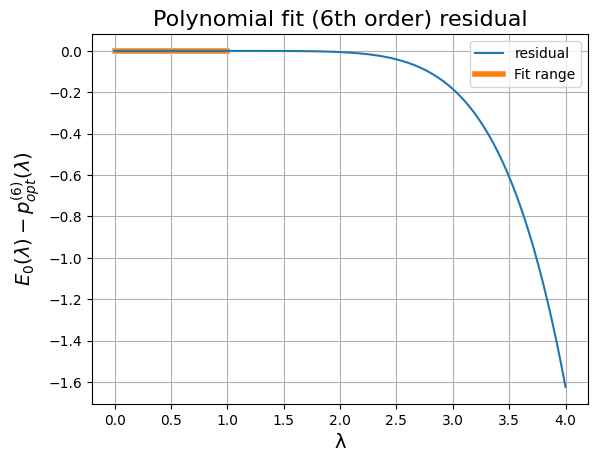

In [6]:
plt.plot(couplings, energies - fn(couplings, *popt_e), label='residual')
plt.plot([0., couplings[25]], [0., 0.], linewidth=4., label='Fit range', zorder=-100.)
plt.legend()
plt.title('Polynomial fit (6th order) residual', fontsize=16)
plt.xlabel('λ', fontsize=14)
plt.ylabel(r'$E_{0}(\lambda) - p^{(6)}_{opt}(\lambda)$', fontsize=14)
plt.grid()

In [7]:
def fn(l, c1, c2, c3, c4):
    return np.sum(np.array([c1, c2, c3, c4]) * np.power(l[..., None], np.arange(1, 5)), axis=-1)

popt_c = np.zeros((4, hdim))
for idx in range(1, hdim):
    plaqs = np.nonzero((idx >> np.arange(nplaq)[::-1]) % 2)[0]
    if len(plaqs) == 1:
        p0 = (1. / 6., 0., 0., 0.)
    elif len(plaqs) == 2:
        if plaqs[0] + 1 == plaqs[1]:
            p0 = (0., 2. / 6. / 2. / 4., 0., 0.)
        else:
            p0 = (0., 2. / 6. / 2. / 6., 0., 0.)
    else:
        p0 = (0., 0., 0., 0.)

    popt, _ = curve_fit(fn, couplings[:25], coeffs[idx, :25], p0=p0)
    popt_c[:, idx] = popt

Text(0.5, 0.98, 'Polynomial fit (4th order)')

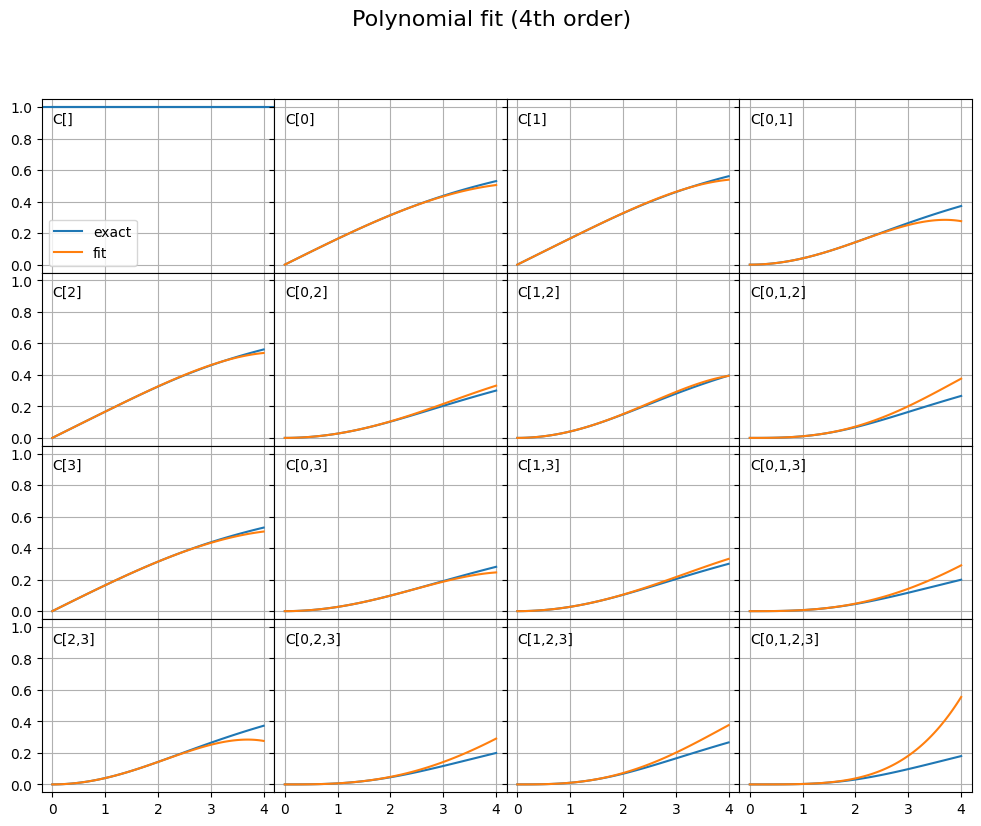

In [8]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=[12, 9])
for idx in range(0, hdim):
    ax = fig.axes[idx]
    exact, = ax.plot(couplings, coeffs[idx])
    if idx == 0:
        ax.axhline(1.)
    else:
        fit, = ax.plot(couplings, fn(couplings, *popt_c[:, idx]))
    ax.grid()
    plaqs = np.nonzero((idx >> np.arange(nplaq)) % 2)[0]
    ax.text(0., 0.9, 'C[' + ','.join(f'{p}' for p in plaqs) + ']')

fig.axes[0].legend([exact, fit], ['exact', 'fit'])
fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('Polynomial fit (4th order)', fontsize=16)

## Analytic values from recursion relation

In [9]:
def analytic_values(nplaq):
    hdim = 2 ** nplaq
    nlink = 2 * nplaq + 1
    energy = np.zeros(5)
    coefficients = np.zeros((4, hdim))

    # O(1)
    energy[0] = float(-nlink)

    # O(λ)
    coefficients[1, 1 << np.arange(nplaq)] = 1. / 6.

    # O(λ^2)
    energy[2] = -np.sum(coefficients[1])
    for ip1 in range(nplaq):
        for ip2 in range(ip1):
            denom = 2. * (4. if ip1 - ip2 == 1 else 6.)
            coefficients[2, (1 << ip1) + (1 << ip2)] = 2. / 6. / denom

    # O(λ^3)
    for idx in range(hdim):
        plaqs = np.nonzero((idx >> np.arange(nplaq)) % 2)[0]
        coeff = np.sum(coefficients[2, idx ^ (1 << np.arange(nplaq))])
        if len(plaqs) == 1:
            coeff += energy[2] * coefficients[1, idx]
            coeff /= 6.
        elif len(plaqs) == 3:
            sigma = 9
            if plaqs[0] + 1 == plaqs[1]:
                sigma -= 2
            if plaqs[1] + 1 == plaqs[2]:
                sigma -= 2
            coeff /= 2. * sigma
        else:
            continue
        coefficients[3, idx] = coeff

    # O(λ^4)
    for ip in range(nplaq):
        energy[4] -= (np.sum(coefficients[2, (1 << ip) ^ (1 << np.arange(nplaq))]) + energy[2] * coefficients[1, 1 << ip]) * coefficients[1, 1 << ip]

    return energy, coefficients

energy, coefficients = analytic_values(nplaq)

Text(0.5, 0, 'Perturbation order (n)')

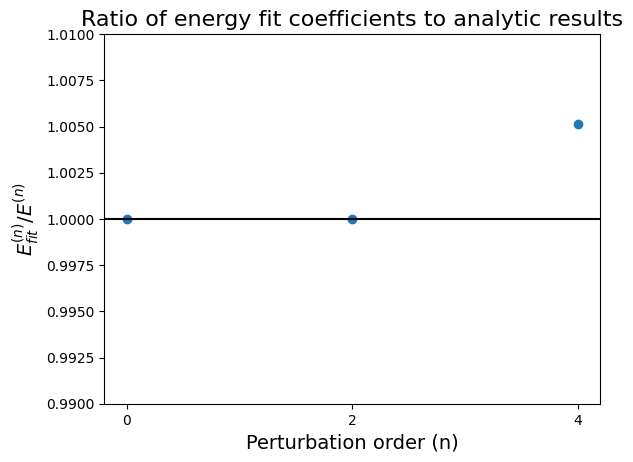

In [10]:
plt.scatter(np.arange(0, 6, 2), popt_e[:3] / energy[::2])
plt.ylim(0.99, 1.01)
plt.axhline(1., color='k')
plt.xticks([0, 2, 4])
plt.title('Ratio of energy fit coefficients to analytic results', fontsize=16)
plt.ylabel('$E_{fit}^{(n)}$/$E^{(n)}$', fontsize=14)
plt.xlabel('Perturbation order (n)', fontsize=14)

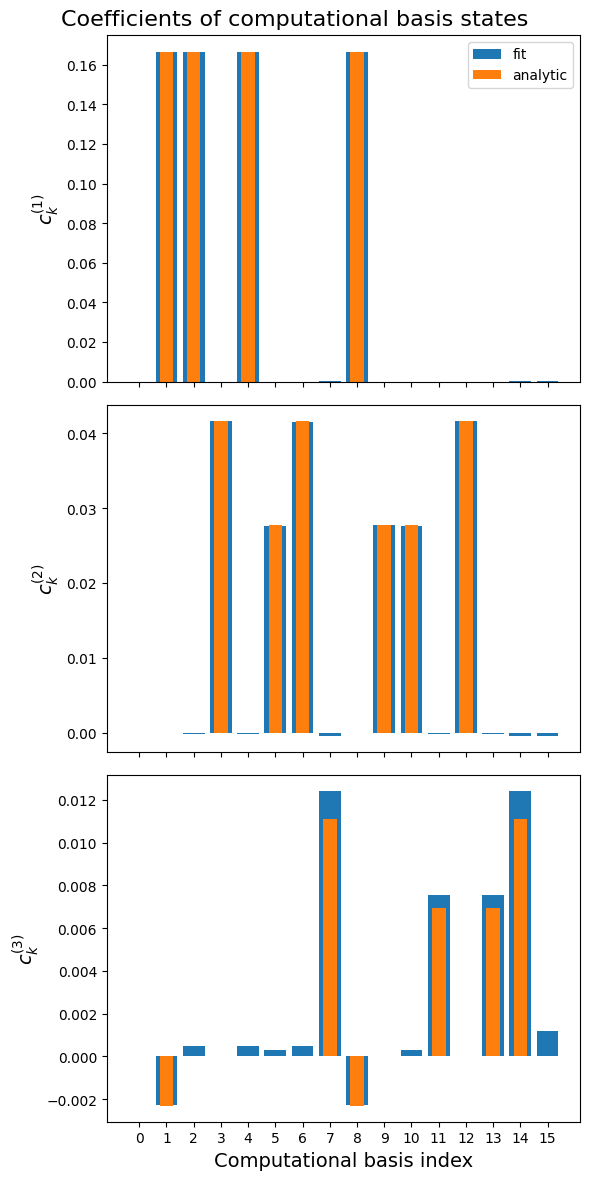

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)
fig.subplots_adjust(hspace=0)
for ax, order in zip(fig.axes, range(1, 4)):
    fit = ax.bar(np.arange(hdim), popt_c[order - 1])
    ana = ax.bar(np.arange(hdim), coefficients[order], width=0.5)
    ax.set_ylabel('$c^{(%d)}_k$' % order, fontsize=14)
   
fig.axes[0].legend([fit, ana], ['fit', 'analytic'])
fig.axes[-1].set_xticks(np.arange(hdim))
fig.axes[-1].set_xlabel('Computational basis index', fontsize=14)
fig.suptitle('Coefficients of computational basis states', fontsize=16)
fig.tight_layout()

## Varying the size of the lattice

In [12]:
nplaqs = np.arange(2, 13)
energy_exps = []
for ipl, nplaq in enumerate(nplaqs):
    energy, coeffs = analytic_values(nplaq)
    energy_exps.append(energy)

In [13]:
energies = []
for ipl, nplaq in enumerate(nplaqs):
    paulis = make_paulis(nplaq)
    energy, coeffs = get_ground_state(paulis, 1.)
    energies.append(energy)

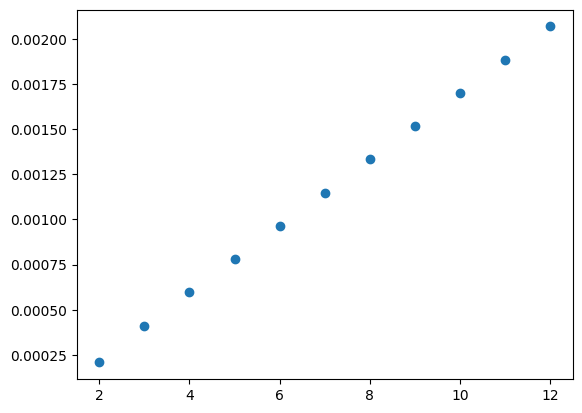

In [14]:
plt.scatter(nplaqs, energies + (2 * nplaqs + 1) + nplaqs / 6. - 1. / 216.)

In [16]:
couplings = np.linspace(0., 2., 20)
popts = []
for ipl, nplaq in enumerate(nplaqs):
    energies, _ = coupling_scan(nplaq, couplings)
    popt_e, _ = fit_energy(couplings, energies, 2 * nplaq + 1, 10)
    popts.append(popt_e)

In [17]:
popts

[array([-4.99999985e+00, -3.33340369e-01,  4.67312667e-03,  1.72634387e-04]),
 array([-6.99999990e+00, -5.00004700e-01,  4.65743504e-03,  3.88121298e-04]),
 array([-8.99999991e+00, -6.66670616e-01,  4.65275233e-03,  5.77240832e-04]),
 array([-1.09999999e+01, -8.33336815e-01,  4.64968015e-03,  7.63877692e-04]),
 array([-1.29999999e+01, -1.00000304e+00,  4.64674585e-03,  9.50324578e-04]),
 array([-1.49999999e+01, -1.16666926e+00,  4.64381963e-03,  1.13675970e-03]),
 array([-1.69999999e+01, -1.33333549e+00,  4.64090933e-03,  1.32318227e-03]),
 array([-1.90000000e+01, -1.50000171e+00,  4.63798554e-03,  1.50961508e-03]),
 array([-2.10000000e+01, -1.66666794e+00,  4.63506639e-03,  1.69604438e-03]),
 array([-2.30000000e+01, -1.83333417e+00,  4.63214897e-03,  1.88247241e-03]),
 array([-2.50000000e+01, -2.00000039e+00,  4.62923529e-03,  2.06889755e-03])]